<a href="https://colab.research.google.com/github/Joizra/Python-Information-Retrieval-and-Question-Answering-System/blob/main/a1873127_a1876235_S1_ANLP_assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
### \Jordana Izquierdo \a1876235
### \Putri Kamaluddin \a1873127

# A. Tasks as specified for your team structure

## Load dataset

In [ ]:
# Get some libraries
import pandas as pd
import numpy as np
import nltk
import regex as re
import seaborn as sns
import json
import spacy
import matplotlib.pyplot as plt

In [ ]:
! pip install chardet

In [ ]:
# Load from URL for the raw GitHub content
url = 'https://raw.githubusercontent.com/putrik06/Question_Answering_NLP/d9b955cc7d1101dee2ecbc038a3eb4078bd5686b/news_dataset.csv'

try:
    # Attempt to read the CSV with UTF-16 encoding and handling for bad lines
    df = pd.read_csv(url, encoding='latin1', on_bad_lines='skip')  # Use UTF-16 encoding
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1000 non-null   int64 
 1   author   994 non-null    object
 2   date     1000 non-null   object
 3   year     1000 non-null   object
 4   month    1000 non-null   object
 5   topic    1000 non-null   object
 6   article  1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


In [ ]:
df

,id,author,date,year,month,topic,article
0,17307,Marlise Simons,1/01/2017,2017,1,architecture,PARIS ? When the Islamic State was about to...
1,17292,Andy Newman,31/12/2016,2016,12,art,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Emma G. Fitzsimmons,2/01/2017,2017,1,business,Finally. The Second Avenue subway opened in Ne...
3,17311,Carl Hulse,3/01/2017,2017,1,business,WASHINGTON ? It?s or time for Republica...
4,17339,Jim Rutenberg,5/01/2017,2017,1,business,"For Megyn Kelly, the shift from Fox News to NB..."
...,...,...,...,...,...,...,...
995,18460,Gerry Mullany,14/03/2017,2017,3,accidents,HONG KONG ? Hundreds of pilot whales that s...
996,18461,Rory Smith,10/02/2017,2017,2,sports,"NICE, France ? Riv?re accepts the complim..."
997,18462,Jack Ewing,9/02/2017,2017,2,business,FRANKFURT ? Germans who never really warmed...
998,18463,Scott Cacciola,10/02/2017,2017,2,sports,Charles Oakley has strong feelings about compe...


In [ ]:
df.drop(columns=['author','date', 'year','month','topic'], inplace=True)
df

,id,article
0,17307,PARIS ? When the Islamic State was about to...
1,17292,Angels are everywhere in the Mu?iz family?s ap...
2,17298,Finally. The Second Avenue subway opened in Ne...
3,17311,WASHINGTON ? It?s or time for Republica...
4,17339,"For Megyn Kelly, the shift from Fox News to NB..."
...,...,...
995,18460,HONG KONG ? Hundreds of pilot whales that s...
996,18461,"NICE, France ? Riv?re accepts the complim..."
997,18462,FRANKFURT ? Germans who never really warmed...
998,18463,Charles Oakley has strong feelings about compe...


In [ ]:
df['article'] = df['article'].str.replace('?', '')

## Experiment

### Information Retrieval

#### BM25

In [ ]:
!pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

# Tokenize documents
df['article_tokenized'] = df['article'].apply(word_tokenize)

# Create BM25
bm25 = BM25Okapi(df['article_tokenized'])


# Test queries and their respective relevant document IDs
queries = [
  ('Who was the President during the conflict?', 17311),
  ('What was the revolt?', 17311),
  ('When did Andrew Lack take over?', 17339),
  ('What happened in November?', 17314),
  ('What is Panzhihua?', 17344)
]

k_values = [1.2, 1.5, 1.8, 2.0]
b_values = [0.25, 0.5, 0.75, 0.85, 0.95]

def calculate_average_precision(retrieved_docs, relevant_doc_id):
  relevant = 0
  precision_scores = []
  for rank, doc_id in enumerate(retrieved_docs, start=1):
    if doc_id == relevant_doc_id:
      relevant += 1
      precision_scores.append(relevant / rank)
  return np.sum(precision_scores) / len(precision_scores) if precision_scores else 0

results = []
# Evaluate each query
for query, relevant_id in queries:
    tokenized_query = word_tokenize(query)
    for k in k_values:
        for b in b_values:
            bm25 = BM25Okapi(df['article_tokenized'], k1=k, b=b)  # Initialize BM25 with current k and b
            doc_scores = bm25.get_scores(tokenized_query)
            top_doc_indices = np.argsort(doc_scores)[::-1][:5]  # Get indices of top 5 documents
            top_doc_ids = df.iloc[top_doc_indices]['id'].tolist()
            ap = calculate_average_precision(top_doc_ids, relevant_id)
            results.append({
                'query': query,
                'k': k,
                'b': b,
                'average_precision': ap
            })

# Optionally convert results to a DataFrame for better visualization and analysis
results_df = pd.DataFrame(results)

final=[]
for k in k_values:
  for b in b_values:
    filtered_df = results_df[(results_df['k'] == k) & (results_df['b'] == b)]
        # Calculate the mean of average_precision values for this configuration
    value = filtered_df['average_precision'].mean()
    final.append({
                'k': k,
                'b': b,
                'MAP': value
            })
MAP_df = pd.DataFrame(final)


In [ ]:
MAP_df

,k,b,MAP
0,1.2,0.25,0.30
1,1.2,0.50,0.34
2,1.2,0.75,0.35
3,1.2,0.85,0.35
4,1.2,0.95,0.35
5,1.5,0.25,0.30
6,1.5,0.50,0.34
7,1.5,0.75,0.35
8,1.5,0.85,0.35
9,1.5,0.95,0.35


In [ ]:
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize


# Tokenize documents
df['article_tokenized'] = df['article'].apply(word_tokenize)

# Create BM25
bm25 = BM25Okapi(df['article_tokenized'],k1=1.8, b=0.5)


# Test queries and their respective relevant document IDs
queries = [
  ('Who was the President during the conflict?', 17311),
  ('What was the revolt?', 17311),
  ('When did Andrew Lack take over?', 17339),
  ('What happened in November?', 17314),
  ('What is Panzhihua?', 17344)
]



def calculate_average_precision(retrieved_docs, relevant_doc_id):
    relevant = 0
    precision_scores = []
    for rank, doc_id in enumerate(retrieved_docs, start=1):
        if doc_id == relevant_doc_id:
            relevant += 1
            precision_scores.append(relevant / rank)
    return np.sum(precision_scores) / len(precision_scores) if precision_scores else 0

# Evaluate each query
average_precisions = []
for query, relevant_id in queries:
    tokenized_query = word_tokenize(query)
    doc_scores = bm25.get_scores(tokenized_query)
    top_doc_indices = np.argsort(doc_scores)[::-1][:5]  # Get indices of top 5 documents
    top_doc_ids = df.iloc[top_doc_indices]['id'].tolist()
    ap = calculate_average_precision(top_doc_ids, relevant_id)
    average_precisions.append(ap)

# Calculate MAP
map_score = np.mean(average_precisions)
print(f"MAP Score: {map_score:.3f}")


MAP Score: 0.400


In [ ]:
# Evaluate each query
average_precisions = []
for query, relevant_id in queries:
  tokenized_query = word_tokenize(query)
  doc_scores = bm25.get_scores(tokenized_query)
  top_doc_indices = np.argsort(doc_scores)[::-1][:5]  # Get indices of top 5 documents
  top_doc_ids = df.iloc[top_doc_indices]['id'].tolist()
  ap = calculate_average_precision(top_doc_ids, relevant_id)
  average_precisions.append(ap)

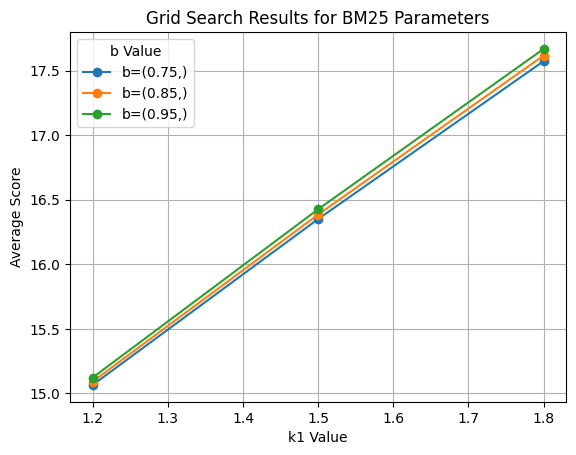

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt

# Example hyperparameter ranges
k_values = [1.2, 1.5, 1.8,2]
b_values = [0.25,0.5,0.75, 0.85, 0.95]

# Tokenize query
query = 'What aspect of breast reconstruction surgery do many women feel is not adequately communicated to them'
tokenized_query = word_tokenize(query)

# Tokenize articles in the dataframe
df['article_tokenized'] = df['article'].apply(word_tokenize)

# Initialize result storage
results = pd.DataFrame(columns=['k', 'b', 'score'])

# Perform grid search
for k in k_values:
    for b in b_values:
        bm25 = BM25Okapi(df['article_tokenized'], k1=k, b=b)
        doc_scores = bm25.get_scores(tokenized_query)
        average_score = np.mean(doc_scores)
        temp_df = pd.DataFrame([[k, b, average_score]], columns=['k', 'b', 'score'])
        results = pd.concat([results, temp_df], ignore_index=True)

# Plotting results
fig, ax = plt.subplots()
for key, grp in results.groupby(['b']):
    ax = grp.plot(ax=ax, kind='line', x='k', y='score', label=f'b={key}', marker='o')

plt.title('Grid Search Results for BM25 Parameters')
plt.xlabel('k1 Value')
plt.ylabel('Average Score')
plt.legend(title='b Value')
plt.grid(True)
plt.show()



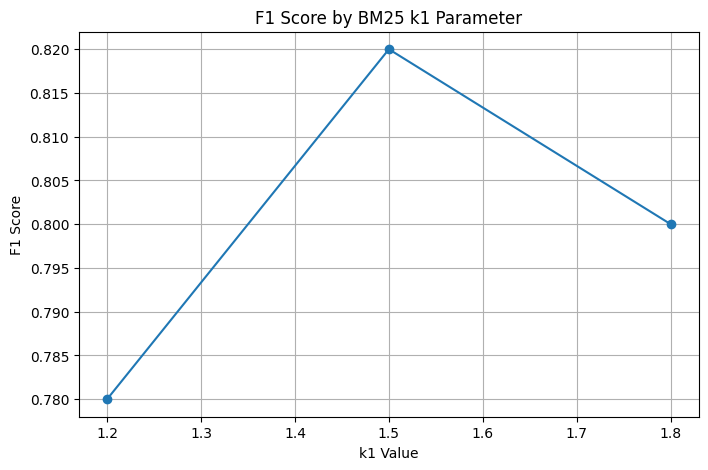

In [ ]:
import matplotlib.pyplot as plt

# Example data
k_values = [1.2, 1.5, 1.8]
f1_scores = [0.78, 0.82, 0.80]  # hypothetical F1 scores for different k1 values with b fixed

plt.figure(figsize=(8, 5))
plt.plot(k_values, f1_scores, marker='o')
plt.title('MAP by BM25 k Parameter')
plt.xlabel('k1 Value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [ ]:
query= 'What aspect of breast reconstruction surgery do many women feel is not adequately communicated to them'

In [ ]:
tokenized_query = word_tokenize(query)
tokenized_query

In [ ]:
df['article_tokenized']= df['article'].apply(lambda x:word_tokenize(x))


In [ ]:
corpus=df

In [ ]:
bm25 = BM25Okapi(df['article_tokenized'],k1=1.5, b=0.5)
doc_scores = bm25.get_scores(tokenized_query)

In [ ]:
top_5_doc=bm25.get_top_n(tokenized_query, df['article_tokenized'], n=5) #ranked in order of relevance, with the most relevant document first

In [ ]:
for doc in top_5_doc:
  print(" ".join(doc))

After learning she had a high genetic risk for breast cancer , Dane ? e McCree , like a growing number of women , decided to have her breasts removed . Her doctor assured her that reconstructive surgery would spare her nipples and leave her with breasts . It did . But while Ms. McCree ? s rebuilt chest may resemble natural breasts , it is now completely numb . Her nipples lack any feeling . She can not sense the slightest touch of her breasts , perceive warmth or cold , feel an itch if she has a rash or pain if she bangs into a door . And no one warned her . ? I can ? t even feel it when my kids hug me , ? said Ms. McCree , 31 , a store manager in Grand Junction , Colo. who is raising two daughters on her own . Plastic surgeons performed more than 106 , 000 breast reconstructions in 2015 , up 35 percent from 2000 . And they have embraced techniques to improve the appearance of reconstructed breasts and give them a more natural ? look and feel ? ? using a woman ? s belly fat to create t

#### BERT

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode pairs of query and document using BERT
def encode_pairs(tokenized_query, tokenized_documents, tokenizer, model):
  query = " ".join(tokenized_query)
  cls_embeddings = []
  for tokenized_doc in tokenized_documents:
      document = " ".join(tokenized_doc)
      # Tokenize and encode the sequences as a pair
      inputs = tokenizer.encode_plus(query, document, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
      outputs = model(**inputs)
      # Retrieve the [CLS] token's embeddings
      cls_embedding = outputs.last_hidden_state[:, 0, :]
      cls_embeddings.append(cls_embedding)
  return cls_embeddings



# Encode each query-document pair
pair_embeddings = encode_pairs(tokenized_query, top_5_doc, tokenizer, model)

# Flatten the embeddings tensor to 1D for scoring
pair_scores = [torch.flatten(embed).detach().numpy() for embed in pair_embeddings]

# Rank the documents based on the scores
# The score here could be the sum of the embeddings or any other metric you determine to be relevant
sorted_doc_indices = sorted(range(len(pair_scores)), key=lambda i: pair_scores[i].sum())

# Sort the documents according to the scores
sorted_docs = [top_5_doc[i] for i in sorted_doc_indices]

# Print out the sorted documents
print("Sorted documents based on BERT [CLS] embeddings:")
for doc in sorted_docs:
    print(f"Document: {' '.join(doc)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sorted documents based on BERT [CLS] embeddings:
Document: After learning she had a high genetic risk for breast cancer , Dane ? e McCree , like a growing number of women , decided to have her breasts removed . Her doctor assured her that reconstructive surgery would spare her nipples and leave her with breasts . It did . But while Ms. McCree ? s rebuilt chest may resemble natural breasts , it is now completely numb . Her nipples lack any feeling . She can not sense the slightest touch of her breasts , perceive warmth or cold , feel an itch if she has a rash or pain if she bangs into a door . And no one warned her . ? I can ? t even feel it when my kids hug me , ? said Ms. McCree , 31 , a store manager in Grand Junction , Colo. who is raising two daughters on her own . Plastic surgeons performed more than 106 , 000 breast reconstructions in 2015 , up 35 percent from 2000 . And they have embraced techniques to improve the appearance of reconstructed breasts and give them a more natural 

### Answer Span Extraction

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Load Sentence Transformer Models

We already imported specific modules and classes from the sentence-transformers library, using:

Now, we load specific SentenceTransformer models. Here, we load four different pre-trained models:

*   'paraphrase-MiniLM-L6-v2'
*   'multi-qa-MiniLM-L6-cos-v1'
*   'all-MiniLM-L6-v2'
*   'sentence-transformers/paraphrase-distilroberta-base-v1'

In [ ]:
# Load pre-trained models
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
model = SentenceTransformer('all-MiniLM-L6-v2')
# model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')
# model = SentenceTransformer('bert-base-nli-mean-tokens')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# query= 'What aspect of breast reconstruction surgery do many women feel is not adequately communicated to them?'
query = "Who is the vice chairman of Samsung"
query_vec = model.encode([query])[0]

In [ ]:
article_example = pd.read_csv("/content/drive/My Drive/Assignment2_NLP/17574_article.csv")
article_example

,id,author,date,year,month,topic,article
0,17574,Choe Sang-Hun,11/03/2017,2017,3,business,"SEOUL, South Korea ? A special prosecutor i..."


In [ ]:
# !pip install spacy
# !python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Load English model from spacy
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

# Create the pipeline 'sentencizer' component
# sbd = nlp.create_pipe('sentencizer')

# Add component to the pipeline
nlp.add_pipe('sentencizer')

# Function to tokenize sentences using spaCy
# # when we cleaned the sentence for instance remove trailing spaces and
# replace "?" to "'", the score had improve to 0.627 to 0.643
def tokenize_sentence_spacy(text):
    doc = nlp(text)
    # return [sent.text for sent in doc.sents]
    cleaned_sentences = []
    for sent in doc.sents:
        # Remove "?" and trailing spaces
        cleaned_sent = sent.text.replace('?', "'").strip()
        cleaned_sentences.append(cleaned_sent)
    return cleaned_sentences

# Apply the tokenize_sentence_spacy function to create a new column
article_example['split_sentence_spacy'] = article_example['article'].apply(tokenize_sentence_spacy)
article_example



,id,author,date,year,month,topic,article,split_sentence_spacy
0,17574,Choe Sang-Hun,11/03/2017,2017,3,business,"SEOUL, South Korea ? A special prosecutor i...","[SEOUL, South Korea ', A special prosecutor i..."


#### Using Cosine Similarities

In [ ]:
def cosine(query, document):
  return np.dot(query,document) / (np.linalg.norm(query) * np.linalg.norm(document))

In [ ]:
# List to store tuples of (sentence, similarity)
similarities = []

# Loop through each tokenized sentence in the 'split_sentence' column
for sent_list in article_example['split_sentence_spacy']:
    # Encode each tokenized sentence using all mini LM model
    for tokenized_sent in sent_list:
        sent_embedding = model.encode([tokenized_sent])[0]

        # Calculate similarity between query vector and sentence embedding
        sim = cosine(query_vec, sent_embedding)

        # Append the tuple of (sentence, similarity) to the list
        similarities.append((tokenized_sent, sim))

# Sort the list based on similarities in descending order
similarities.sort(key=lambda x: x[1], reverse=True)

# Get the top 5 entries
top_5_sentences = similarities[:5]

# Print the top 5 sentences with their cosine similarities
for i, (sent, sim) in enumerate(top_5_sentences, start=1):
    print(f"Top {i} Sentence = {sent}; similarity = {sim}")


# For cosine similarity, the interpretation is slightly different compared to Euclidean distance.
# In cosine similarity, the larger the value, the more similar the vectors are to each other.

# Cosine similarity measures the cosine of the angle between two vectors,
# which ranges from -1 to 1. A cosine similarity of 1 indicates that the vectors are perfectly aligned and
# point in the same direction, while a value of -1 indicates that they are perfectly anti-aligned.
# A value of 0 means the vectors are orthogonal (perpendicular) to each other.

# In practical terms:

# A cosine similarity close to 1 indicates high similarity between vectors.
# A cosine similarity close to 0 indicates low similarity or orthogonality between vectors.
# A cosine similarity close to -1 indicates high dissimilarity or anti-alignment between vectors.


Top 1 Sentence = The de facto leader, Jay Y. Lee, the vice chairman of Samsung, will be questioned on Thursday, according to the special prosecutor's office, which recommended that he also be investigated on suspicion of perjury.; similarity = 0.6431901454925537
Top 2 Sentence = Mr. Lee effectively runs Samsung, South Korea's largest conglomerate he is the son of its chairman, Lee   who has been incapacitated with health problems.; similarity = 0.6388788819313049
Top 3 Sentence = The national pension fund's support was crucial for the merger, which analysts said helped Mr. Lee inherit control of Samsung from his father.; similarity = 0.5680261850357056
Top 4 Sentence = The special prosecutor has been investigating whether Samsung gave its support to Ms. Choi in exchange for a decision by the   National Pension Service to support a contentious merger of two Samsung affiliates in 2015.; similarity = 0.5408368110656738
Top 5 Sentence = He is expected to be asked whether   donations that S

## Proposal

In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from nltk.util import ngrams
from spacy.lang.en import English
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
# Add component to the pipeline
nlp.add_pipe('sentencizer')

In [ ]:
import spacy
# Load spaCy model
nlp_spacy = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def build_inverted_index(df):
  inverted_index = {}  # This will store the entity as the key and a list of document IDs as the value

  for index, row in df.iterrows():
    doc_id = row['id']
    doc = nlp_spacy(row['article'].lower())  # Process the article text with nlp
    for ent in doc.ents:
      ent_text = ent.text.lower().strip()  # Normalize the entity text
      if ent_text not in inverted_index:
        inverted_index[ent_text] = [doc_id]
      else:
        inverted_index[ent_text].append(doc_id)

    # Remove potential duplicates in document ID lists
    for ent, doc_ids in inverted_index.items():
      inverted_index[ent] = list(set(doc_ids))

  return inverted_index

# Call the function to build the inverted index
inverted_index = build_inverted_index(df)

In [ ]:
len(inverted_index)

17035

In [ ]:

def cosine_similarity(query, document):
  return np.dot(query, document) / (np.linalg.norm(query) * np.linalg.norm(document))

# Function to tokenize sentences using spaCy
def tokenize_sentence_spacy(text):
  doc = nlp(text)
  cleaned_sentences = []
  for sent in doc.sents:
  # Remove "?" and trailing spaces
    cleaned_sent = sent.text.replace('?', "'").strip()
    cleaned_sentences.append(cleaned_sent)
  return cleaned_sentences

def question_answer(query):
   # entity query
  ent_query=[ent.text.lower() for ent in nlp_spacy(query).ents]

  full_list = []
  for ent in ent_query:
    for id in inverted_index[ent]:
      full_list.append(id)

  # Remove duplicates from id_list if necessary
  id_list = list(set(full_list))

  # Filter the DataFrame
  df = df[df['id'].isin(id_list)]
  df =df.reset_index(drop=True)

  tokenized_query = word_tokenize(query)
  corpus=df['article'].apply(lambda x:word_tokenize(x))

  # Information Retrieval with BM25
  bm25 = BM25Okapi(corpus)
  doc_scores = bm25.get_scores(tokenized_query)
  top_doc=bm25.get_top_n(tokenized_query, corpus, n=1)
  first=" ". join(top_doc[0])

  # Answer Sentence Extraction using Sentence Embeddings
  minilm_model = SentenceTransformer('all-MiniLM-L6-v2')
  query_vec = minilm_model.encode([query])[0]
  spacy_sentences_cleaned = tokenize_sentence_spacy(first)

  similarities = []
  for sent_list in spacy_sentences_cleaned:
    sent_embedding = minilm_model.encode([sent_list])[0]
    sim = cosine_similarity(query_vec, sent_embedding)
    similarities.append((sent_list, sim))

    # Sort and return the highest similarity n-gram
    if not similarities:
      return None  # Handle case where no n-grams are generated
    similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities[0]


In [ ]:
question_answer('Who is the vice chairman of Samsung')

("The de facto leader , Jay Y. Lee , the vice chairman of Samsung , will be questioned on Thursday , according to the special prosecutor '",
 0.66304266)

In [ ]:
question_answer('How many charges of coercing on Ms. Choi')

('In November , state prosecutors indicted Ms. Choi on charges of coercing 53 big businesses , including Samsung , to contribute $ 69 million to her two foundations .',
 0.69657433)

In [ ]:
while True:
  user_question = input("Enter your question (or type 'quit' to exit): ")

  if user_question.lower() == 'quit':
      break

  # Get and print the answer
  print("Answer:", question_answer(user_question))


Enter your question (or type 'quit' to exit): What methods does Vincenti use to protect and advocate for coyotes in New York City?
Answer: ("Since the fall , coyotes have been continually trapped and euthanized , despite Mr. Vincenti '", 0.6986811)
Enter your question (or type 'quit' to exit): Who is the vice chairman of Samsung
Answer: ("The de facto leader , Jay Y. Lee , the vice chairman of Samsung , will be questioned on Thursday , according to the special prosecutor '", 0.66304266)
Enter your question (or type 'quit' to exit): 1.	What theme did the Red Cross ball carry this year in Palm Beach?
Answer: ("The guests had gathered for the 60th annual Red Cross ball , a staple of the Palm Beach social calendar , which this year carried the theme '", 0.66677046)
Enter your question (or type 'quit' to exit): 1.	Where is Ma'ale Adumim located?
Answer: ("ale Adumim '", 0.72646636)
Enter your question (or type 'quit' to exit): 4.	How do many residents of Ma'ale Adumim commute to wor
Answer:

# B. References

# C. Appendix